Time series analysis on the feature trends, to try predicting feature trend of a unit with time.

First some library imports and data loading functions

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import itertools
import warnings
import matplotlib.dates as mdate

warnings.filterwarnings("ignore")
Y_LIMS = {
    'rpm': (-20, 1500),
    'motor_voltage': (0, 400),
    'motor_current': (-20, 100),
    'motor_temp': (-20, 250),
    'inlet_temp': (-20, 250),
}

def load_unit_data(unit):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    file_df = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name)) 
    file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
    file_df.set_index('timestamp', inplace=True)
    return file_df

def get_last_proportion(unit, feature, proportion=0.1):
    df_unit = load_unit_data(unit)
    index_prop = int(len(df_unit.index) * (1- proportion))
    return df_unit[index_prop: ]

def log_data(unit, feature_name, proportion):
    df_data = get_last_proportion(unit, feature_name, proportion)
    return np.log(df_data[feature_name])

def plot_feature_in_single_file(feature_name, unit, ylim_low=None, ylim_high=None, bins=20, show_dist=True):
    file_df = load_unit_data(unit)
    sns.set()
    fig, axs = plt.subplots(2 if show_dist else 1, 1, figsize=(16, 10))
    subplot_idx = 211 if show_dist else 111
    ax1 = fig.add_subplot(subplot_idx)
    if ylim_low is not None or ylim_low is not None:
        file_df[feature_name].plot(ylim=(ylim_low, ylim_high))
    else:
        file_df[feature_name].plot(ylim=Y_LIMS[feature_name])

    #xticks_count = 30
    #xtick_dates_indexes = [int(n) for n in np.arange(0, len(file_df.index), step=len(file_df.index) / xticks_count)]
    #xticks_dates = [datetime.datetime.strptime(file_df.index[i][:19], '%Y-%m-%d %H:%M:%S') for i in xtick_dates_indexes]

    if show_dist == True:
        ax2 = fig.add_subplot(212)
        sns.distplot(file_df[feature_name], bins=bins)
    plt.show()

Take a look at the rpm value trend of unit 0012 with time

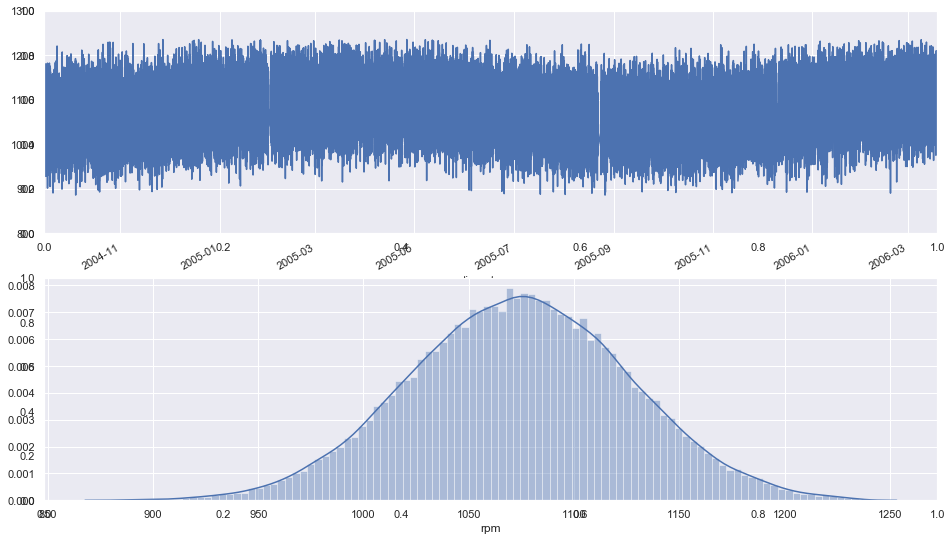

In [12]:
plot_feature_in_single_file("rpm", 12, ylim_low=800, ylim_high=1300, bins=100, show_dist=True)

Try ARIMA time series modeling on feature trend of a single unit.

Peek at the rolling mean & std for feature rpm on unit 0000

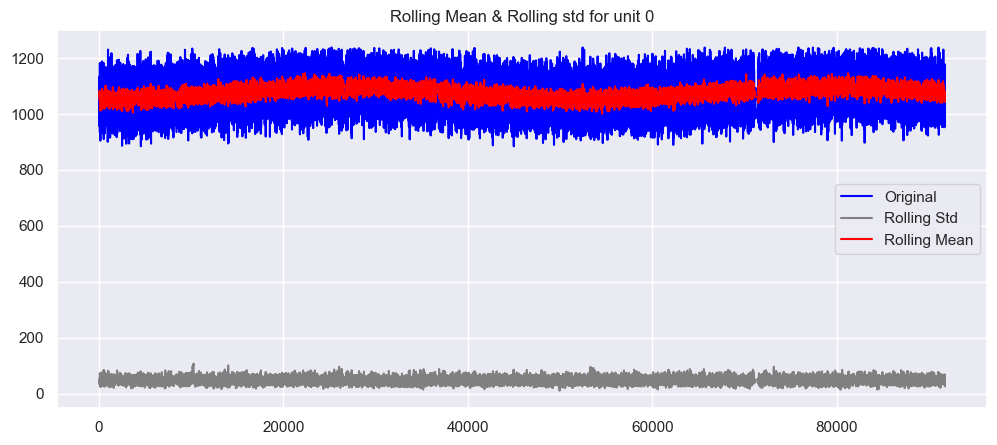

In [81]:
def plot_rolling_mean_std(unit, feature, window=12, ylim_low=-10, ylim_high=1500, figsize=None):
    df_unit = load_unit_data(unit)[[feature]]
    rolling_mean = df_unit.rolling(window=window).mean()
    rolling_std = df_unit.rolling(window=window).std()

    plt.figure(figsize=figsize, dpi=100)
    plt.plot(df_unit, color='blue', label='Original')
    plt.plot(rolling_std, color='grey', label='Rolling Std')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt_title = 'Rolling Mean & Rolling std for unit {}'.format(unit)
    plt.title(plt_title)
    plt.show()

plot_rolling_mean_std(0, 'rpm', figsize=(12, 5))

The rolling mean & std of feature rpm in all units

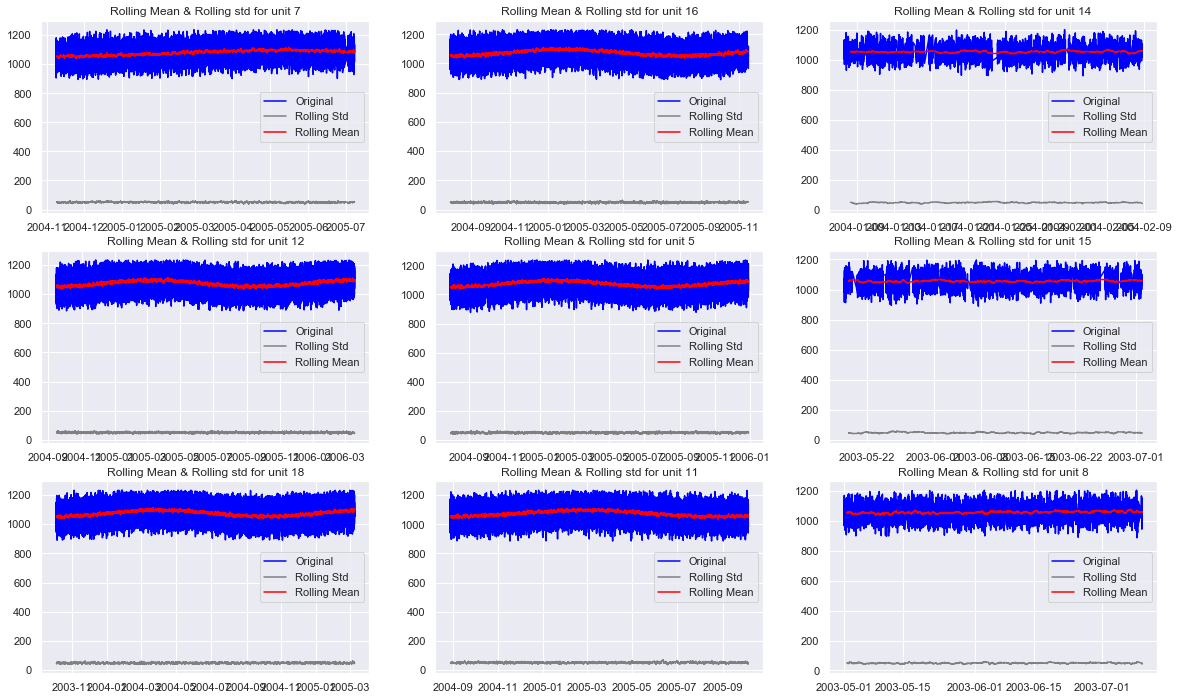

In [7]:
def plot_rolling_meas_stds(feature, window=12, ylim_low=-10, ylim_high=1500):
    units = random.sample(range(0, 20), 9)
    #units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, unit in enumerate(units):
        ax = plt.subplot(3, 3, idx + 1)
        df_unit = load_unit_data(unit)[[feature]]
        rolling_mean = df_unit.rolling(window=window).mean()
        rolling_std = df_unit.rolling(window=window).std()
        
        ax.plot(df_unit.index, df_unit[feature], color='blue', label='Original')
        ax.plot(rolling_std, color='grey', label='Rolling Std')
        ax.plot(rolling_mean, color='red', label='Rolling Mean')
        ax.legend(loc='best')
        ax.set_title('Rolling Mean & Rolling std for unit {}'.format(unit))
    plt.show()
    
plot_rolling_meas_stds('rpm', window=100)

The rolling mean & std of feature motor_voltage in all units

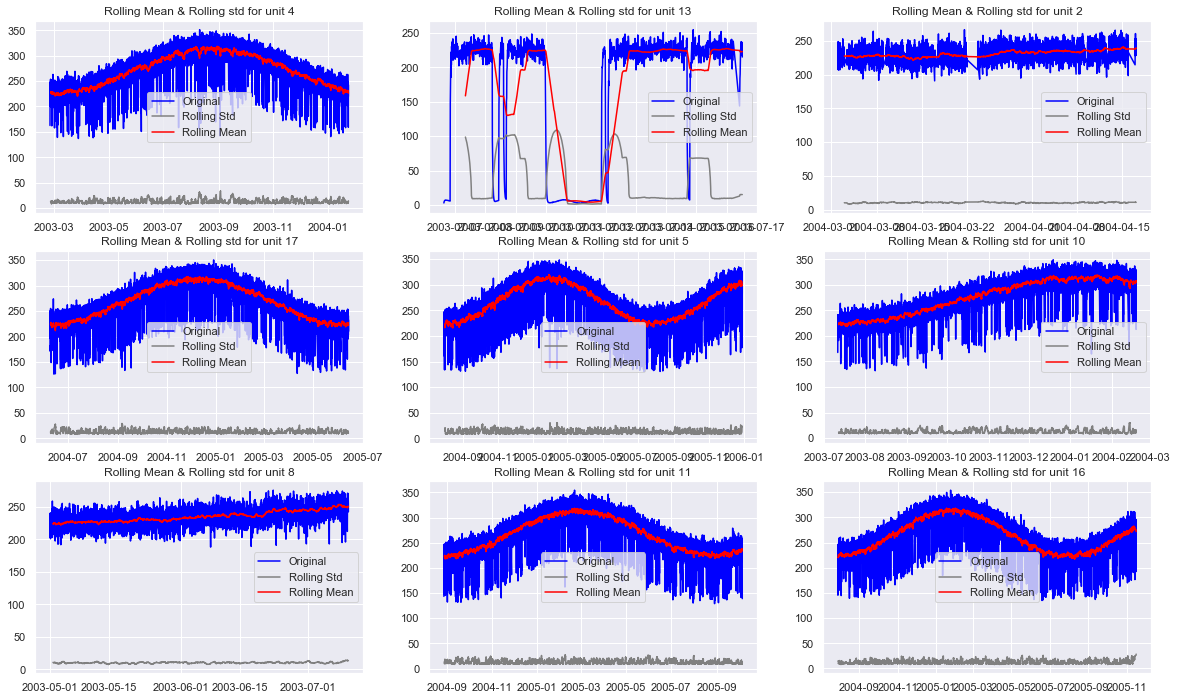

In [6]:
plot_rolling_meas_stds('motor_voltage', window=100)

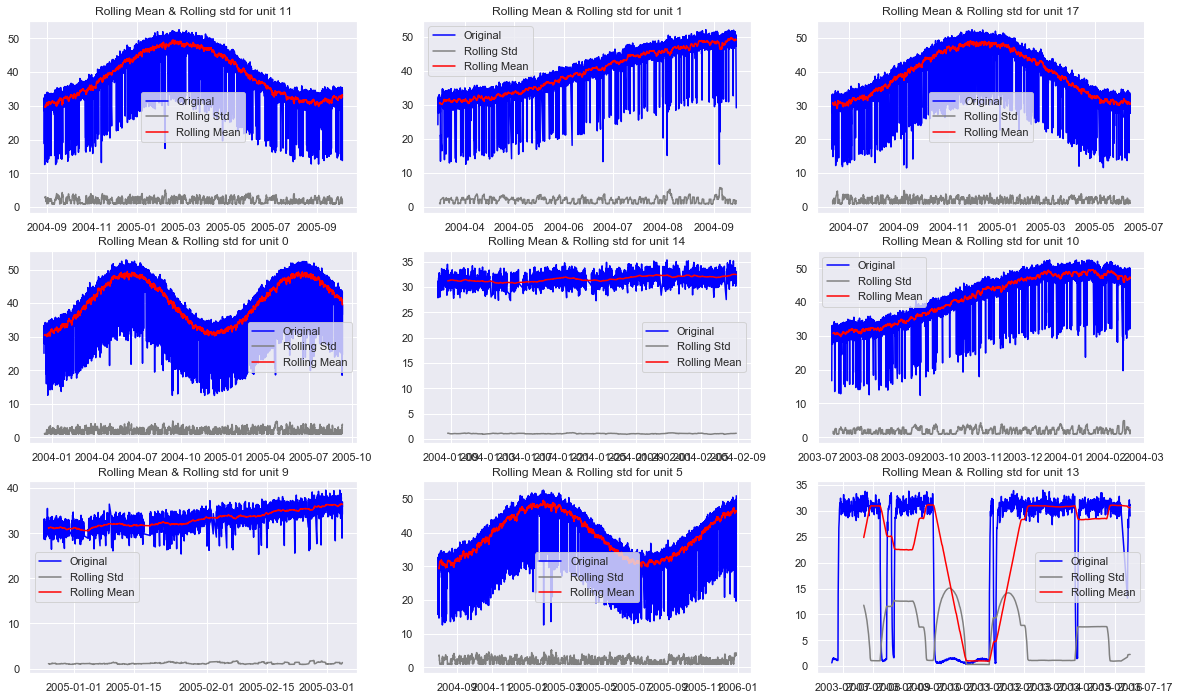

In [11]:
plot_rolling_meas_stds('motor_current', window=150)

The rolling mean & std of feature motor_temp in all units

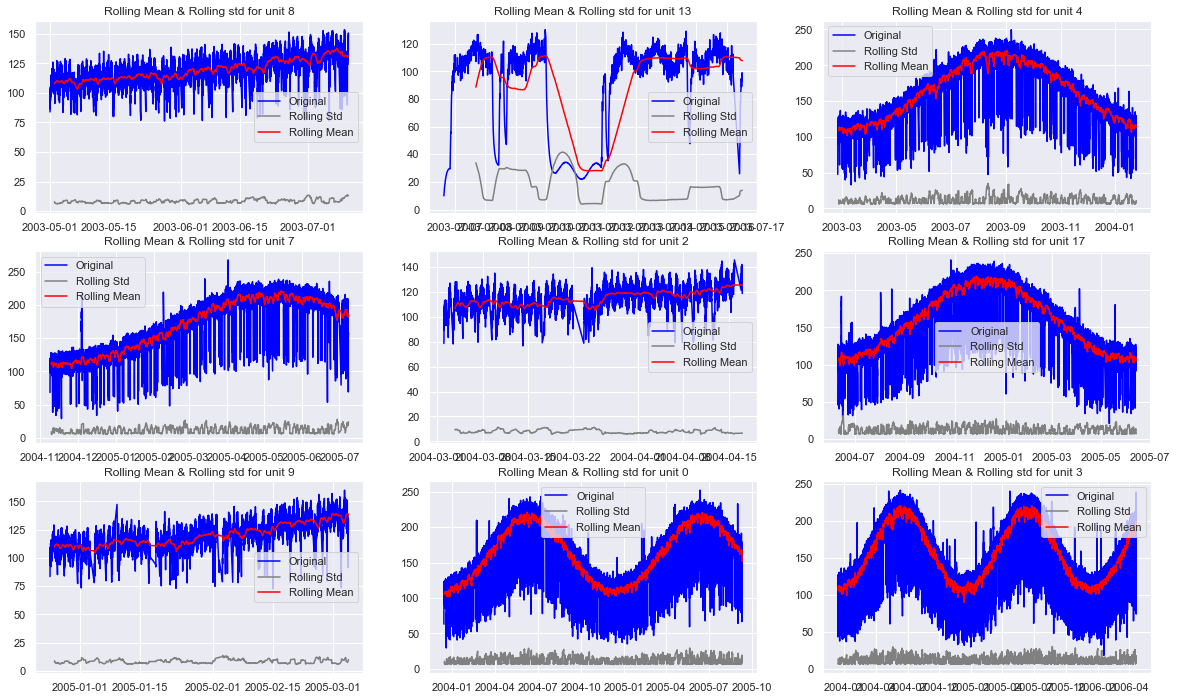

In [9]:
plot_rolling_meas_stds('motor_temp', window=150)

Try to use time series models to predict motor_voltage for unit 0019

First use ad-fullter test to test stationarity of feature trends

In [15]:
def adfuller_test(unit, feature, proportion=0.05, log=False):
    #df_unit = load_unit_data(unit)[[feature]] 
    df_last_prop = get_last_proportion(unit, feature, proportion=proportion)
    if log == True:
        df_last_prop[feature] = np.log(df_last_prop[feature])
    
    adf_result = adfuller(df_last_prop[feature])
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
adfuller_test(19, 'motor_voltage')

ADF Statistic: -8.357128
p-value: 0.000000


The p-value is smaller than threshold 0.05, so the trend is stationary. Take a peek of motor_voltage of unit 0019.

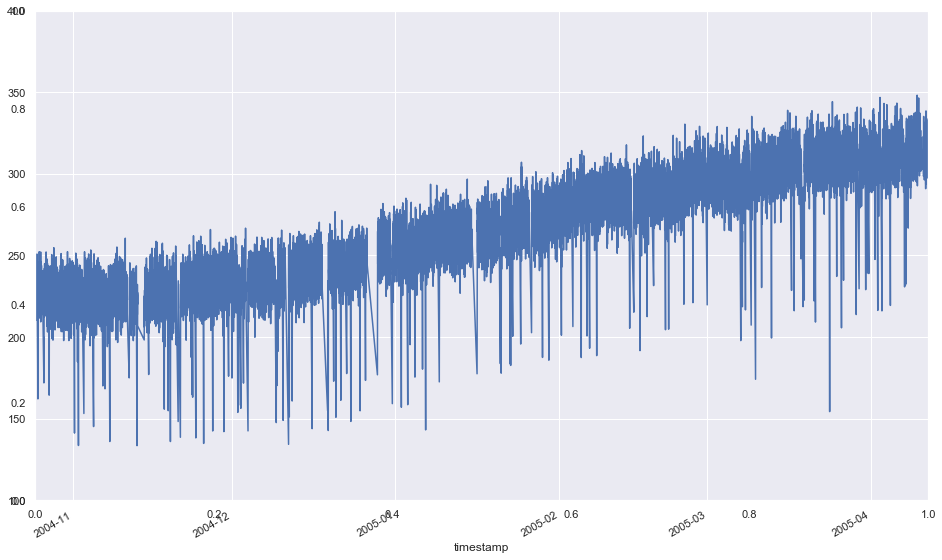

In [14]:
plot_feature_in_single_file("motor_voltage", 19, ylim_low=100, ylim_high=400, bins=100, show_dist=False)

Plot the latest part

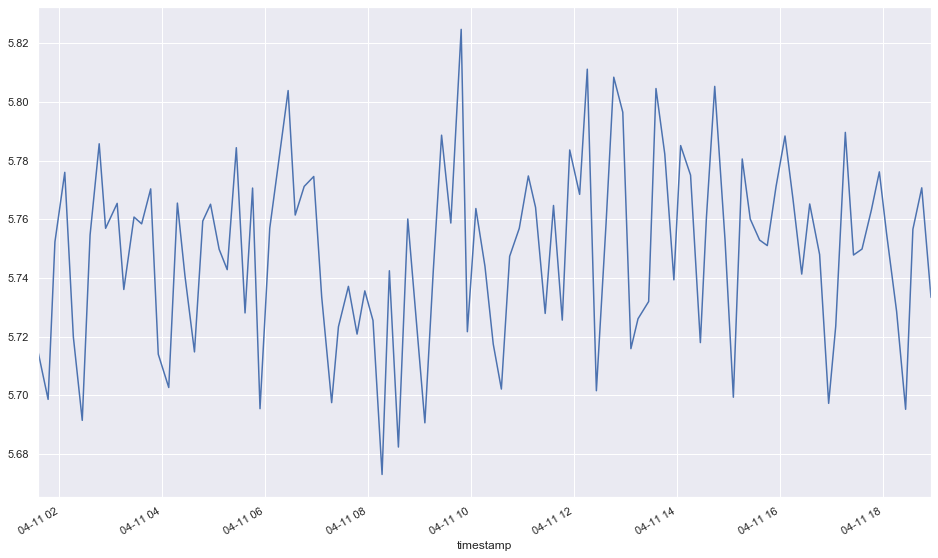

In [22]:
def plot_last_daily_trend(unit, feature, proportion=0.01, log=False):
    df_last_prop = get_last_proportion(unit, feature, proportion=proportion)
    if log == True:
        df_last_prop[feature] = np.log(df_last_prop[feature])
    sns.set()
    fig, axs = plt.subplots(figsize=(16, 10))
    df_last_prop[feature].plot()
plot_last_daily_trend(19, 'motor_voltage', proportion=0.005, log=True)

Plot the autocorrelation & partial autocorrelation of motor_voltage for unit 0019

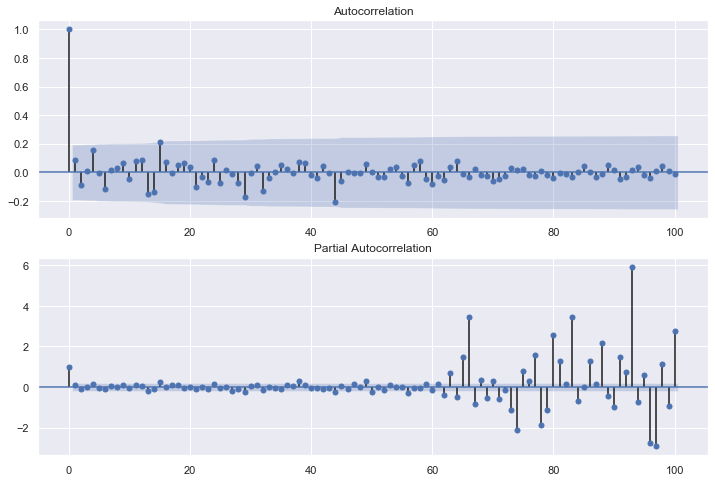

In [23]:
def plot_acf_pacf(unit, feature, proportion=0.05, lags=50):
    df_last_prop = get_last_proportion(unit, feature, proportion=proportion)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_last_prop[feature], lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df_last_prop[feature], lags=lags, ax=ax2)
plot_acf_pacf(19, "motor_voltage", proportion=0.005, lags=100)

In [86]:
def grid_search_SARIMAX(unit, feature, val_range=(0, 3), skip_diff=True, proportion=0.05, log=False):
    P = D = Q = range(val_range[0], val_range[1])
    if skip_diff:
        D = [0]
    PDQ = list(itertools.product(P, D, Q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in PDQ]
    #df_unit = load_unit_data(unit)[feature] 
    if log == False:
        df_unit = get_last_proportion(unit, feature, proportion=proportion)[feature]
    else:
        df_unit = np.log(get_last_proportion(unit, feature, proportion=proportion)[feature])
    
    index_p85_input = int(len(df_unit.index) * 0.85)
    train_input = df_unit[:index_p85_input]
    test_input = df_unit[index_p85_input:]
    params_best, param_seasonal_best, AIC_best = None, None, float("inf")
    best_AIC = float("inf")
    for param in PDQ:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_input, order=param, seasonal_order=param_seasonal,
                                                enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                if best_AIC > results.aic:
                    params_best, param_seasonal_best, best_AIC = param, param_seasonal, results.aic
                    print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

            except Exception as ex:
                print(ex.message)
                continue
    print("best hyperparameters by grid search: ARIMA{}, Seasonal{}".format(params_best, param_seasonal_best))

In [18]:
def peek_attributes_last_trend(feature_name, proportion=0.05, ylim_low=-10, ylim_high=1500):
    units = random.sample(range(0, 20), 9)
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, unit in enumerate(units):
        df_unit = get_last_proportion(unit, feature_name, proportion=proportion)
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        ax1 = plt.subplot(3, 3, idx + 1)
        df_unit[feature_name].plot(ylim=(ylim_low, ylim_high))
        ax1.set_title("{} {}".format(unit_name, feature_name))
    plt.show()


Train SARIMA model for unit 0019 motor_voltage. Differencing is set to 0 due to data stationarity. p and q are both set since there're cut-offs in autocorrelation and partial autocorrelation. Grid search is used to find the best param combinations.

In [135]:
def train_SARIMAX(unit, feature, order, seasonal_order, proportion=0.05, log=False):
    #df_unit = get_last_proportion(unit, feature, proportion=proportion)[feature]
    if log == False:
        df_unit = get_last_proportion(unit, feature, proportion=proportion)[feature]
    else:
        df_unit = np.log(get_last_proportion(unit, feature, proportion=proportion)[feature])
    index_p85 = int(len(df_unit.index) * 0.85)
    train = df_unit[:index_p85]
    test = df_unit[index_p85:]
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=-1)
    print(model_fit.summary())
#     plt.figure(figsize=(12, 5), dpi=100)
#     plt.plot(train, label='actual')
#     plt.plot(model_fit.fittedvalues[1:], label='fitted')
#     plt_title = "SARIMAX fitted vs actual on {} of unit {}".format(feature, unit)
#     plt.title(plt_title)
#     plt.legend(loc="upper left")
    return model_fit

model_motor_voltage_19 = train_SARIMAX(19, "motor_voltage", (1, 0, 2), (2, 0, 1, 24), proportion=0.005, log=True)

                                 Statespace Model Results                                 
Dep. Variable:                      motor_voltage   No. Observations:                   87
Model:             SARIMAX(1, 0, 2)x(2, 0, 1, 24)   Log Likelihood                  72.819
Date:                            Tue, 24 Dec 2019   AIC                           -131.639
Time:                                    09:47:47   BIC                           -120.175
Sample:                                         0   HQIC                          -127.560
                                             - 87                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7213      0.288      2.501      0.012       0.156       1.286
ma.L1         -0.8888      0.588   

The small AIC value indicates a good fit. Use the trained SARIMA to predict the future 15% data

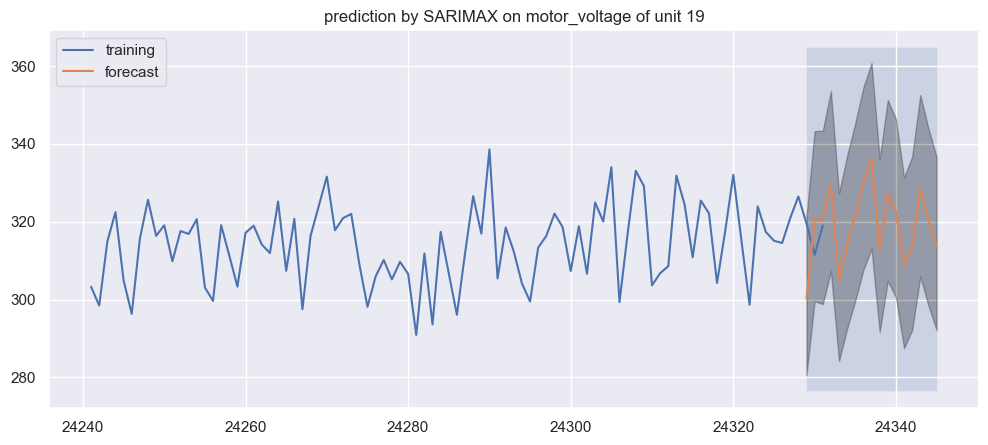

In [151]:
def SARIMAX_predict(model, unit, feature, proportion=0.05):
    #df_unit = load_unit_data(unit)[feature]
    df_unit = get_last_proportion(unit, feature, proportion=proportion)[feature]
    index_p85 = int(len(df_unit.index) * 0.85)
    #start, end = df_unit.index[index_p85], df_unit.index[-1]
    start, end = index_p85, len(df_unit.index)
    df_last_p15_index = df_unit[(index_p85 - 1):].index
    forecast = np.exp(model.predict(start=start, end=end, dynamic=True))
    df_forecast = pd.DataFrame(forecast, index=df_last_p15_index)
    forecast = pd.DataFrame(forecast.values, index=df_last_p15_index.tolist())
    #print(forecast.values.flatten())

    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 5), dpi=100)
    predict = model.get_prediction(start=start, end=end, dynamic=False)
    pred_ci = predict.conf_int()
    ax = sns.lineplot(x=df_unit[:index_p85 + 2].index, y=df_unit[:index_p85 + 2].values, label='training')
    ax.fill_between(forecast.index, np.exp(pred_ci.iloc[:, 0]), np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.3)
    ax.fill_betweenx(ax.get_ylim(), forecast.index[0], forecast.index[-1], alpha=.2, zorder=-1)
    sns.lineplot(x=forecast.index, y=forecast.values.flatten(), label='forecast')
    plt_title = "prediction by SARIMAX on {} of unit {}".format(feature, unit)
    plt.title(plt_title)
    plt.legend(loc='upper left')

SARIMAX_predict(model_motor_voltage_19, 19, "motor_voltage", proportion=0.005)

In [88]:
grid_search_SARIMAX(19, 'motor_voltage', val_range=(0, 3), skip_diff=True, proportion=0.05, log=True)

ARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:5531.113513213271
ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:4315.312079486868
ARIMA(0, 0, 0)x(0, 0, 2, 24) - AIC:3251.0046457485323
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:-2281.7259705122196
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:-2804.361518537904
ARIMA(1, 0, 0)x(2, 0, 2, 24) - AIC:-2823.2952941519134
ARIMA(1, 0, 1)x(0, 0, 0, 24) - AIC:-3105.0906952201085
ARIMA(1, 0, 2)x(0, 0, 0, 24) - AIC:-3106.006647344292
best hyperparameters by grid search: ARIMA(1, 0, 2), Seasonal(0, 0, 0, 24)


Make another attempt to predict temperatures: motor_temp for unit 0018.

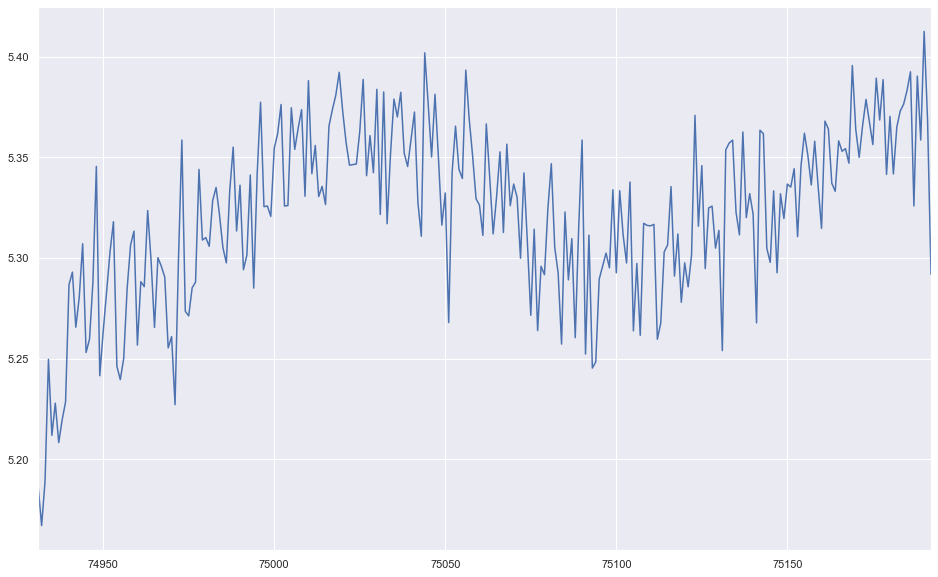

In [98]:
plot_last_daily_trend(18, 'motor_temp', proportion=0.004, log=True)

Autocorrelations & partial autocorrelation

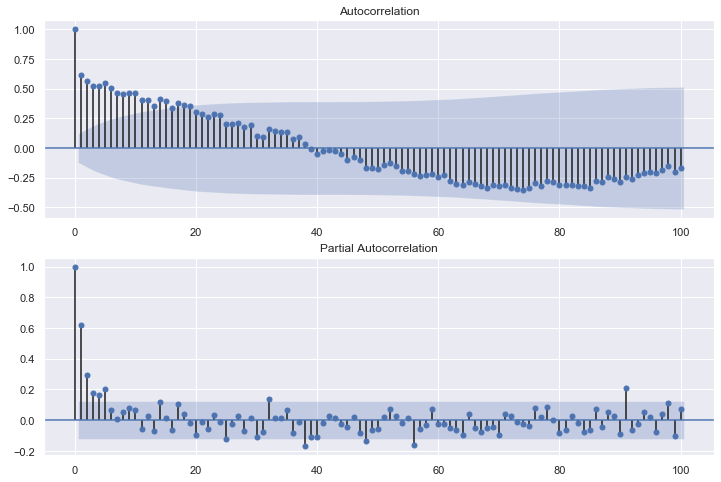

In [99]:
plot_acf_pacf(18, "motor_temp", proportion=0.004, lags=100)

ad-fullter test indicates stationarity

In [118]:
adfuller_test(18, 'motor_temp', 0.04, log=True)

ADF Statistic: -10.348557
p-value: 0.000000


In [121]:
grid_search_SARIMAX(18, 'motor_temp', val_range=(0, 3), skip_diff=True, proportion=0.04, log=True)

ARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:13464.401446345244
ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:10509.529008128888
ARIMA(0, 0, 0)x(0, 0, 2, 24) - AIC:8127.449312564132
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:-2044.0765610088583
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:-3264.4306863240377
ARIMA(0, 0, 1)x(1, 0, 1, 24) - AIC:-4321.814243619185
ARIMA(0, 0, 2)x(1, 0, 1, 24) - AIC:-4688.069861047369
ARIMA(1, 0, 0)x(0, 0, 0, 24) - AIC:-4979.837984973627
ARIMA(1, 0, 0)x(1, 0, 1, 24) - AIC:-5091.385671679471
ARIMA(1, 0, 1)x(0, 0, 0, 24) - AIC:-5119.522359344432
ARIMA(1, 0, 2)x(0, 0, 0, 24) - AIC:-5179.612253776758
ARIMA(2, 0, 1)x(0, 0, 0, 24) - AIC:-5252.084886033014
best hyperparameters by grid search: ARIMA(2, 0, 1), Seasonal(0, 0, 0, 24)


Train SARIMAX based on grid search.

In [136]:
model_motor_temp_18 = train_SARIMAX(18, "motor_temp", (2, 0, 1), (5, 0, 1, 24), proportion=0.004, log=True)

                                 Statespace Model Results                                 
Dep. Variable:                         motor_temp   No. Observations:                  218
Model:             SARIMAX(2, 0, 1)x(5, 0, 1, 24)   Log Likelihood                 206.884
Date:                            Tue, 24 Dec 2019   AIC                           -393.767
Time:                                    09:49:41   BIC                           -368.124
Sample:                                         0   HQIC                          -383.402
                                            - 218                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8705      0.132      6.620      0.000       0.613       1.128
ar.L2         -0.0157      0.114   

predictions by SARIMAX with confidence .

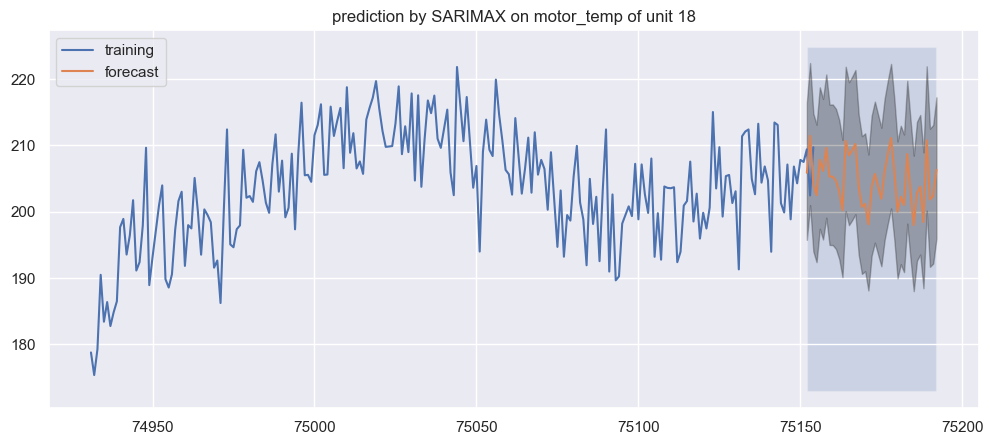

In [152]:
SARIMAX_predict(model_motor_temp_18, 18, "motor_temp", proportion=0.004)